# <b> 0 Install module and Import Libraries </b>

First, installing *pygsheets* and importing necessary libraries.

ติดตั้ง *pygsheets* และนำเข้า library ที่จำเป็นต้องใช้

In [ ]:
!pip install pygsheets

In [ ]:
import pygsheets
import warnings
import google.auth
from google.colab import auth

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression

# set maximum row to unlimit
pd.options.display.max_rows = 999
warnings.filterwarnings('ignore')
auth.authenticate_user() #access google
credentials, _ = google.auth.default()
gc = pygsheets.client.Client(credentials)

# <b> 1 Import Data </b>

<!-- The table below shows the data that we will analyze. The data are collected from various sources and merged into one spreadsheet. There are 214 entries and 23 features. However, we don't need to use all these features, we just select some features that are relevant to what we want to analyze. -->

ตารางด้านล่างนี้แสดงถึงข้อมูลที่จะนำมาวิเคราะห์ ซึ่งรวบรวมมาจากหลายแหล่งและนำมารวมกันเป็นตารางเดียว ข้อมูลนี้มีทั้งหมด 214 entries และมี 23 features แต่อย่างไรก็ตาม เราจะไม่นำข้อมูลทั้งหมดนี้มาใช้
หากแต่จะเลือกมาใช้มาแค่บาง feature ที่เกี่ยวข้องกับสิ่งที่เราต้องการจะวิเคราะห์ <br />
ข้อมูลที่เป็นตารางใหญ่ ๆ นี้จะนำมาใช้เป็น data mart

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1cMI20xn10MtdGXIWocs5eyHPfLWYjrBr60txz_vza6E/edit?usp=sharing'
sheet = gc.open_by_url(url)

# Get data from google sheet
dat = sheet.sheet1.get_as_df()
dat.set_index('Country', inplace=True)

display(dat.head(5))
print(dat.shape)

,GDP 2019,latest GDP,latest GDP capita,GDP growth 2020,Agriculture,Industry,Manufacturing,Service,GHRP,Unemployment rate 2019,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,Population_Size,Population density,Physician density,Hospital bed density
Country,,,,,,,,,,,,,,,,,,,,
Afghanistan,,1421411.00,502.1155,-5,21.1344,22.0891,11.1025,52.0839,Yes,23.9,44503.0,1675.0,35422.0,7406.0,114.32030,3.763791,37172386,53.57,0.28,0.5
Albania,1678431,1678431.00,5352.8570,-7.5,18.6275,20.0573,6.28252,48.5818,No,13.8,32196.0,685.0,15469.0,16042.0,1118.77100,2.127593,2866376,106.35,1.20,2.9
Algeria,20428344,20428344.00,3948.3430,-5.5,11.9744,37.4112,24.283,45.9358,No,11.7,73774.0,2255.0,48183.0,23336.0,168.23770,3.056632,42228429,17.49,1.83,1.9
Angola,,26777992.00,2973.5910,-4,8.60774,47.9315,6.05947,43.2069,Yes,6.6,14413.0,336.0,7273.0,6804.0,43.85347,2.331229,30809762,24.35,0.21,0.8
Antigua and Barbuda,,4348.54,17790.3100,-17.3,1.75779,21.4365,2.48663,66.7531,No,11,139.0,4.0,128.0,7.0,141.94100,2.877698,96286,216.63,2.76,3.8


(171, 20)


# <b> 2 Data Preparation  </b>

ถ้าข้อมูลมีกระจุกตัวกันมากเกินไป จะทำให้ machine learning จะตรวจจับลักษณะของตัวแปรได้ยาก จึงต้องทำการแปลงข้อมูลก่อน 

ซึ่งในที่นี้จะใช้ logarithm transformation
\begin{equation*}
x' = \log_{10} (x + 1)
\end{equation*}

เกณฑ์ในการแปลงคือจะใช้ค่า skewness ถ้าค่า skewness มากกว่าค่าใดค่าหนึ่ง ก็จะแปลง logarithm transformation <br />
เมื่อแปลงแล้วจะเห็นว่าความเบ้และการกระจายข้อมูลบางตัวน้อยลง นอกจากนี้การกระจายเข้าใกล้กับ normal distribution มากขึ้น ซึ่งทำให้เหมาะแก่การนำไปใช้กับ machine learning มากขึ้น

In [ ]:
# Load data from data mart
features = ['Confirmed', 
          'Deaths', 
          'Incident_Rate',
          'Case_Fatality_Ratio',
          'latest GDP', 
          'latest GDP capita', 
          'Agriculture', 
          'Industry', 
          'Manufacturing',
          'Service', 
          'Population_Size',
          'Hospital bed density', 
          'Physician density',
          'GDP growth 2020' 
          ]

dat_used = dat[features]
 
n_features = len(dat_used.columns)

for x in dat_used.columns :
  dat_used[x] = pd.to_numeric(dat_used[x], errors='coerce')

display(dat_used.head())
print(dat_used.shape)

,Confirmed,Deaths,Incident_Rate,Case_Fatality_Ratio,latest GDP,latest GDP capita,Agriculture,Industry,Manufacturing,Service,Population_Size,Hospital bed density,Physician density,GDP growth 2020
Country,,,,,,,,,,,,,,
Afghanistan,44503.0,1675.0,114.32030,3.763791,1421411.00,502.1155,21.134390,22.08905,11.102530,52.08388,37172386.0,0.5,0.28,-5.0
Albania,32196.0,685.0,1118.77100,2.127593,1678431.00,5352.8570,18.627490,20.05732,6.282522,48.58177,2866376.0,2.9,1.20,-7.5
Algeria,73774.0,2255.0,168.23770,3.056632,20428344.00,3948.3430,11.974390,37.41122,24.282960,45.93583,42228429.0,1.9,1.83,-5.5
Angola,14413.0,336.0,43.85347,2.331229,26777992.00,2973.5910,8.607742,47.93154,6.059469,43.20691,30809762.0,0.8,0.21,-4.0
Antigua and Barbuda,139.0,4.0,141.94100,2.877698,4348.54,17790.3100,1.757789,21.43646,2.486629,66.75313,96286.0,3.8,2.76,-17.3


(171, 14)


In [ ]:
# Checking missing values
print("Number of Missing Values")
print(dat_used.isna().sum(axis=0))

# Remove all entries containing missing values
dat_used.dropna(axis=0, how='any', inplace=True)

print('Remove all entries containing missing values')

Number of Missing Values
Confirmed               0
Deaths                  0
Incident_Rate           0
Case_Fatality_Ratio     0
latest GDP              0
latest GDP capita       0
Agriculture             1
Industry                1
Manufacturing           1
Service                 1
Population_Size         4
Hospital bed density    0
Physician density       0
GDP growth 2020         5
dtype: int64
Remove all entries containing missing values


Histogram before Log-transformation --------------------------------------------


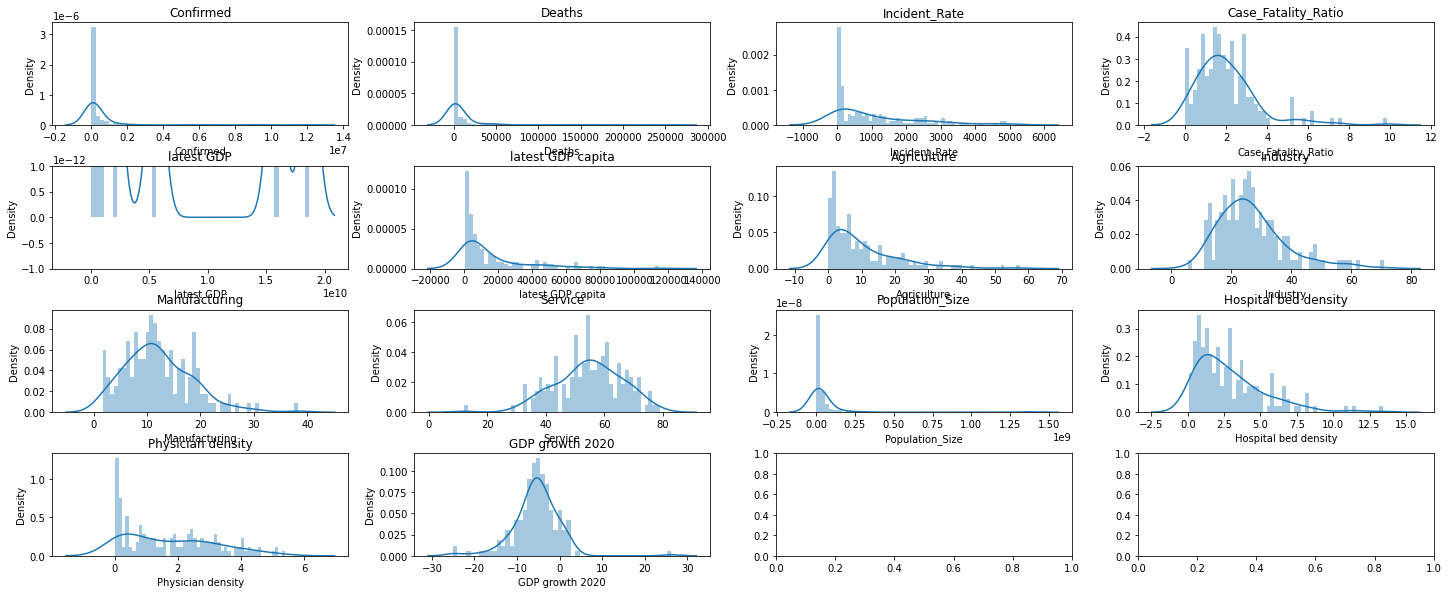

transformed features :
Confirmed 6.983932253391308
Deaths 6.0452746496833605
Case_Fatality_Ratio 1.8304726247319683
latest GDP 8.274120414288117
latest GDP capita 2.0588389240589784
Agriculture 1.7453153531359977
Population_Size 7.6138862417562905
Hospital bed density 1.5046544527345425

Histogram after Log-transformation --------------------------------------------


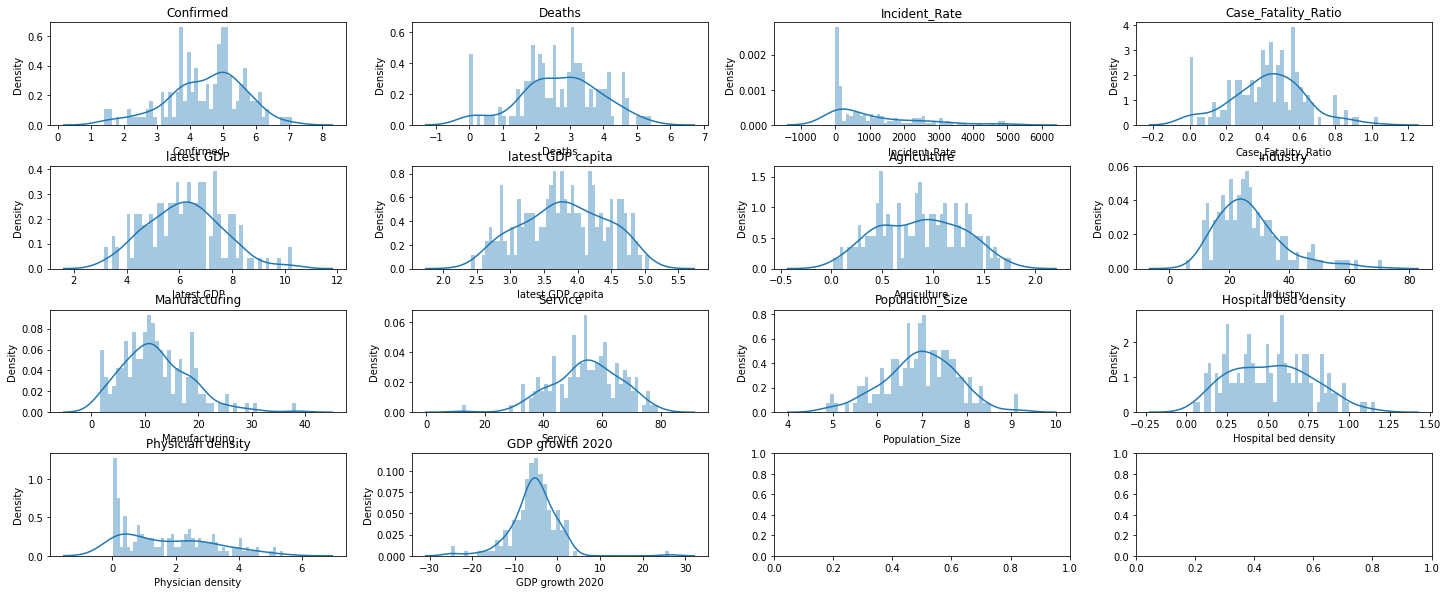

In [ ]:
fig, ax = plt.subplots(4, 4, figsize = (20, 8))
ax = ax.flatten()
fig.tight_layout()
fig.subplots_adjust(wspace=0.225, hspace=0.4)

print('Histogram before Log-transformation --------------------------------------------')
for i in range(len(dat_used.columns)) :
    sns.distplot(dat_used[dat_used.columns[i]], ax=ax[i], bins=50)
    ax[i].set_title(dat_used.columns[i])
plt.show()

print('transformed features :')
dat_untransformed = dat_used.copy()
for s in dat_used.columns :
  skewness = stats.skew(dat_used[s])
  if  skewness > 1.3 :
    dat_used[s] = np.log10(dat_used[s] + 1)
    print(s, skewness)

print()
print('Histogram after Log-transformation --------------------------------------------')
fig, ax = plt.subplots(4, 4, figsize = (20, 8))
ax = ax.flatten()
fig.tight_layout()
fig.subplots_adjust(wspace=0.225, hspace=0.4)
for i in range(len(dat_used.columns)) :
    sns.distplot(dat_used[dat_used.columns[i]], ax=ax[i], bins=50)
    ax[i].set_title(dat_used.columns[i])
plt.show()

# <b> 3 Analysis  </b>

## <b>*1*.What factors affect GDP growth?</b>

<!-- In this topic, we want to study what factors affect GDP growth.
So, we will focus on GDP growth as the dependent variable and observe that how other features influence GDP growth. -->

ในหัวข้อนี้ต้องการจะศึกษาว่ามีปัจจัยใดบ้างในช่วงของการแพร่ระบาดของ Covid-19 ที่ส่งผลกระทบต่อการเจริญเติบโตทางเศรษฐกิจ (GDP)  
ดังนั้นเราจะโฟกัสที่ GDP growth เป็นหลัก และดูว่า feature อื่น ๆ ส่งผลกระทบกับตัวแปรตัวนี้อย่างไร

สำหรับคนที่งงว่า GDP คืออะไร
GDP ย่อมาจาก **Gross Domestic Product** แปลให้เข้าใจง่ายคือ การที่นับรายได้ที่เกิดขึ้นจากในประเทศเท่านั้น ไม่ว่าจะสัญชาติใดก็ตาม

**ถ้าค่า GDP เป็นบวก** แสดงถึงภาพรวมเศรษฐกิจที่มีการเติบโตขึ้น มีเม็ดเงินหมุนเวียนในประเทศมากขึ้น หรือว่าง่ายๆคือ ประเทศรวยขึ้น

**ถ้าค่า GDP เป็นลบ** แสดงถึงภาพรวมเศรษฐกิจที่มีการชะลอตัวเลง มีเม็ดเงินหมุนเวียนในประเทศลดลง หรือว่าง่ายๆคือ ประเทศจนลง

<!---Firstly, we select features that might affect GDP growth in 2020. In fact, we don't need to do it by hand, but we can use various techniques to select features automatically, for example,

<ul>
<li> independence test such as Chi-square test or Wald test, </li>
<li> correlation, </li>
<li> feature importance of decision tree, </li>
<li> Recursive Feature Elimination, </li>
<li> etc </li>
</ul><br />

However, If we want to use these techniques, the data must be imputed (be filled missing values) first, and it will be complicated because there are too many features, and some are time series, some are categorical data. Thus, we simply select these features by hand, then perform imputation.

<br /><br />-->

อันดับแรก เราจะเลือก features ที่น่าจะมีผลกระทบกับการเติบโตของ GDP ในปี 2020
ซึ่งเราสามารถนำหลักเทคนิคของกระคำนวณทางสถิตมาใช้ในการคัดเลือก feature ที่มีความสัมพันธ์กับตัวแปรที่เราต้องการจะสำรวจ 

อาทิเช่น

<ul>
<li> Independence test such as Chi-square test or Wald test, </li>
<li> Correlation, </li>
<li> Decision Tree, </li>
<li> Recursive Feature Elimination, </li>
<li> ฯลฯ </li>
</ul><br />


สิ่งที่เราอยากรู้ก็คือจำนวนตัวเลขของการติดเชื้อ Covid-19 , อัตราความรุนแรงในแต่ละประเทศนั้นมีผลกระทบรุนแรงต่ออัตราการเจริญเติบโตทางเศรษฐกิจ(GDP Growth) มากน้อยเพียงใด

เราจึงนำเอา Feature ดังนี้มาศึกษาหาความสัมพันธ์: 
1. จำนวนตัวเลขผู้ติดเชื้อทั้งหมดจนถึง ณ Data ล่าสุดใน Dataframe(Confirmed)
2. จำนวนของผู้เสียชีวิต (Deaths)
3. อัตราการเสียชีวิต (Case_Fatality_Ratio)

โดยเราใช้วิธีการหา 
1. หาความสัมพันธ์ระหว่างตัวแปร (Correlation Matrix)
2. Decision Tree 

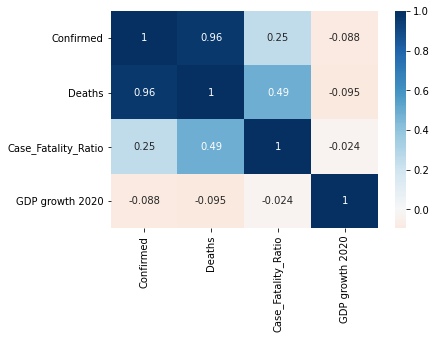

In [ ]:
features = ['Confirmed', 
          'Deaths', 
          'Case_Fatality_Ratio',
          'GDP growth 2020']

df = dat_used[features]
df_untransformed = dat_untransformed[features]

for x in features :
  df[x] = pd.to_numeric(df[x], errors='coerce')
  df_untransformed[x] = pd.to_numeric(df[x], errors='coerce')

df.dropna(how='any', axis=0, inplace=True)
df_untransformed.dropna(how='any', axis=0, inplace=True)

sns.heatmap(df.corr(), cmap='RdBu', annot=True, center=0)
plt.show()

ด้วยหลักการทั้งสอง ผลลัพธ์ที่ได้นั้น เราจะเห็นได้ว่า  ตัวเลขทางเศรษฐกิจ นั้นจะแย่ลง เนื่องจาก Features ทั้งสองได้แก่ จำนวนผู้ติดเชื้อ Covid-19 และ ยอดของการเสียชีวิต มีความสัมพันธ์ที่มีการแปรผันกลับกัน ทำให้เมื่อยอดผู้ติดเชื้อหรือเสียชีวิตเพิ่มขึ้น เราจะเห็นการถดถอยของการเจริญเติมโตทางเศรษฐกิจตกต่ำลง 

Regular axes ----------------------------------------------------------------------------------------------------


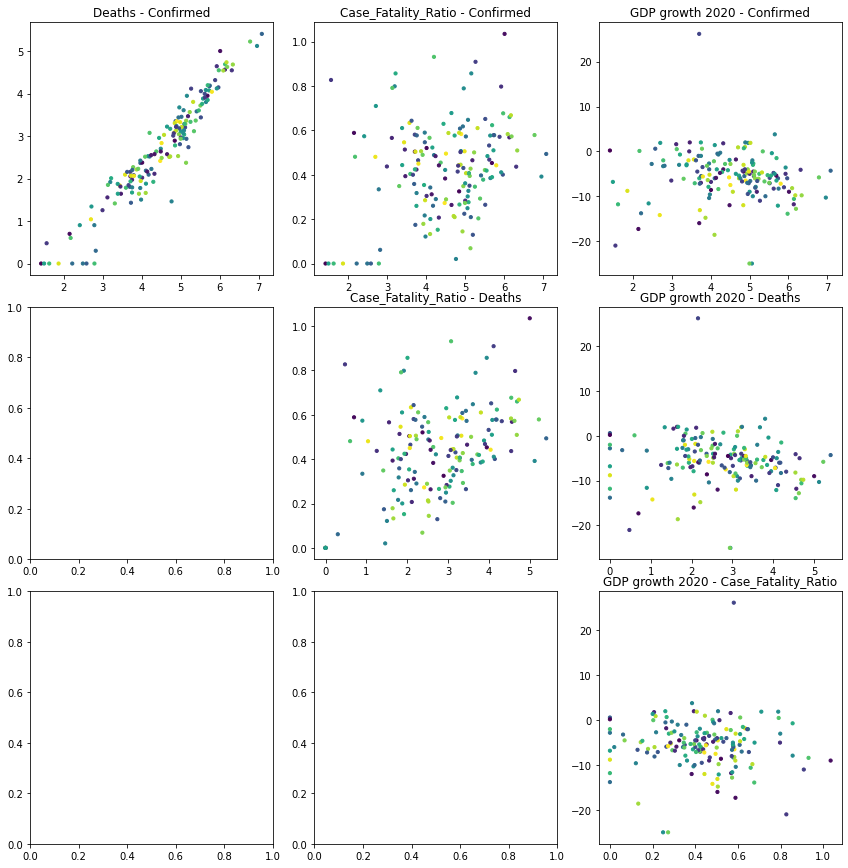

Projection to PCA axes ----------------------------------------------------------------------------------------------------


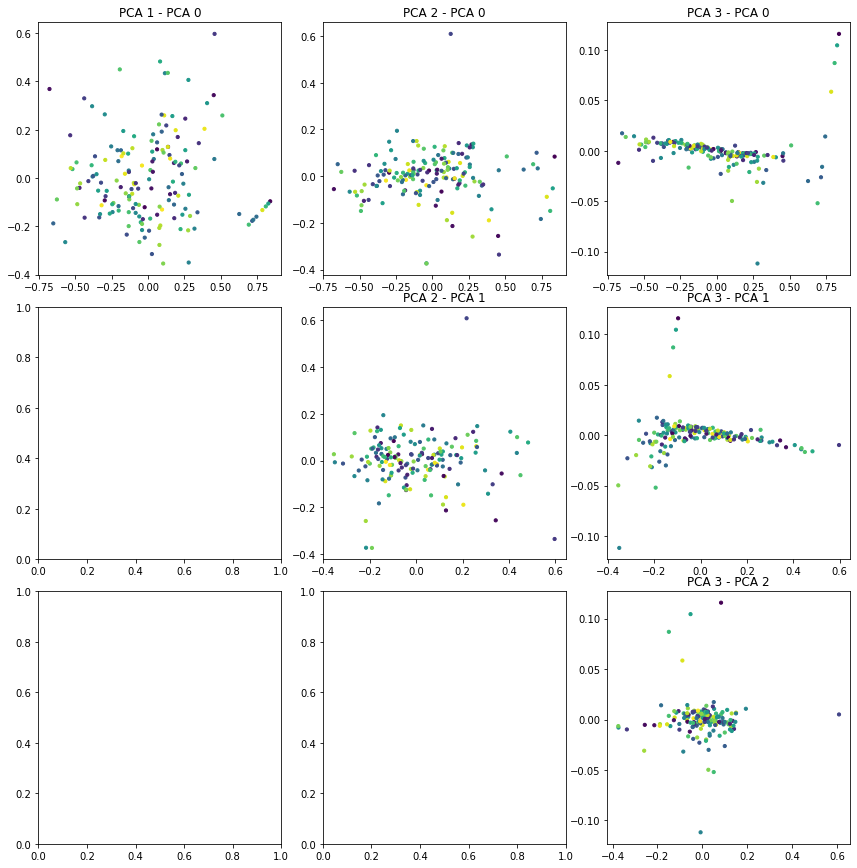

In [ ]:
X = df.values
X_scaled = MinMaxScaler().fit_transform(X)
X_pca    = PCA().fit_transform(X_scaled)
y        = df.values[:, -1]

print('Regular axes ' + '-'*100)
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
fig.tight_layout()

for i in range(4) :
    for j in range(i+1, 4) :
        sc = ax[i][j-1].scatter(X[:, i], X[:, j], s=10, c=np.argsort(y))
        ax[i][j-1].set_title(df.columns[j] + " - " + df.columns[i])
plt.show()

print('Projection to PCA axes ' + '-'*100)

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
fig.tight_layout()

for i in range(4) :
    for j in range(i+1, 4) :
        sc = ax[i][j-1].scatter(X_pca[:, i], X_pca[:, j], s=10, c=np.argsort(y))
        ax[i][j-1].set_title('PCA '+str(j)+" - "+'PCA '+str(i))
plt.show()

Mean Square Error
0.0


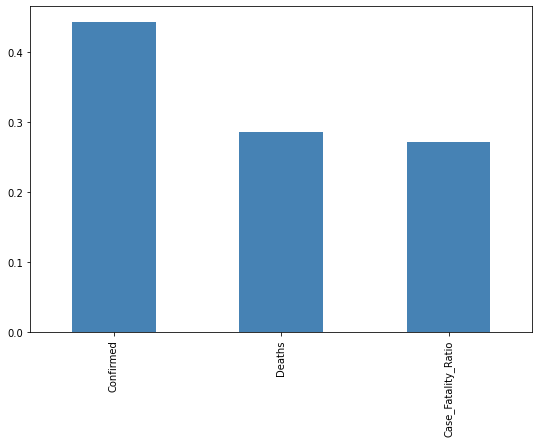

Ranking of feature importance ---------------------------------
1 Confirmed
2 Deaths
3 Case_Fatality_Ratio


In [ ]:
rgs = DecisionTreeRegressor().fit(X_scaled[:,:-1], y)
#for i, j in zip(y, rgs.predict(X_scaled)) :
#  print(i, j)

print('Mean Square Error')
print(np.sum((df.values[:, -1] - rgs.predict( X_scaled[:, :-1] ))**2)/len(df.index))

plt.figure()
pd.Series(rgs.feature_importances_, index=df.columns[:-1]).plot.bar(color='steelblue', figsize=(9, 6))
plt.show()

print('Ranking of feature importance ---------------------------------')
j = 1
for i in df.columns[np.argsort(rgs.feature_importances_)[::-1]] :
  print(j, i)
  j+=1

เราจึงได้ Plot PCA เพื่อที่จะได้จุดกลุ่มประเทศที่ตัวเลขของการเจริญเติมโตทางเศรษฐกิจ ,จำนวนการติดเชื้อ และ และจำนวนผู้เสียชีวิต เป็นกลุ่มๆ เพื่อจะได้นำไปศึกษาต่อในเชิงลึก

โดยเราได้เลือกใช้ DBScan Clustering แทน ซึ่งเหมาะสมกับชุดข้อมูลที่ไม่จำเป็นต้องเป็นแบบ Normal Distribution
ทว่าข้อเสียของ DBScan นั้นคือ เมื่อมีกลุ่มชุดข้อมูลที่เป็นไม่ได้จับใกล้เคียงกับชุดข้อมูลอื่นๆ ก็จะถูกนับเป็น Outlier หรือ ไม่สามารถถูกจัดให้อยู่ในกลุ่มข้อมูลใดได้

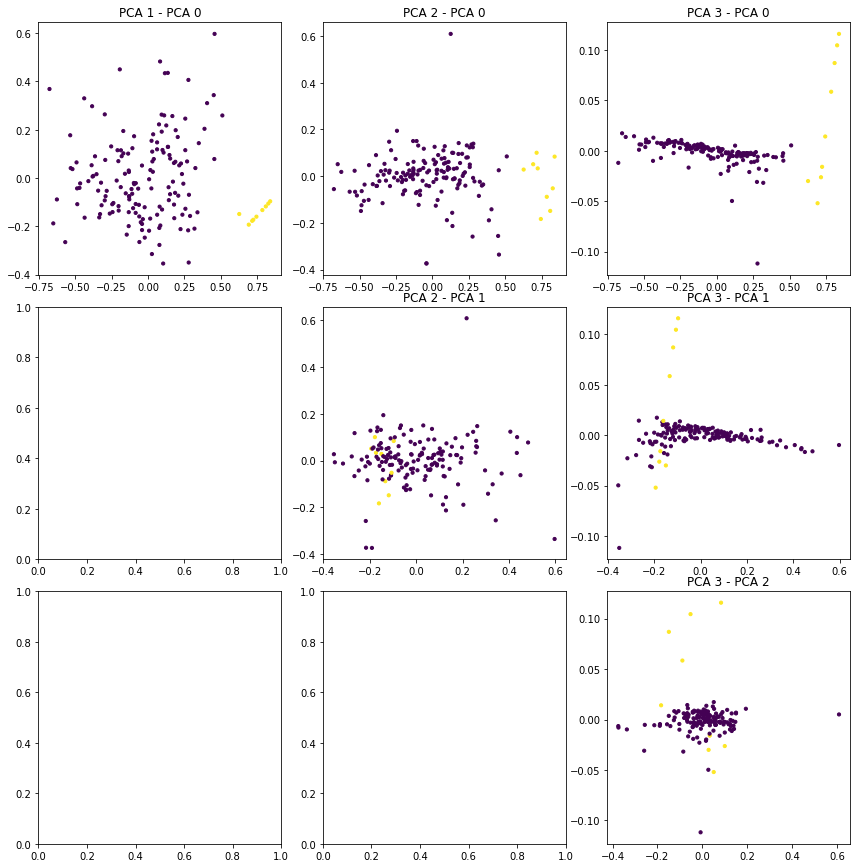

In [ ]:
y_DBscan = DBSCAN(eps=0.26).fit_predict(X_scaled[:, :-1])
#y_DBscan = DBSCAN(eps=0.2).fit_predict(X_scaled[:, :-1])
#y_kmean  = KMeans(n_clusters=2).fit_predict(X[:, :-1])

unique_group = np.unique(y_DBscan)
group = tuple([tuple(df.loc[y_DBscan==i].index.values) for i in np.sort(unique_group)])

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
fig.tight_layout()

for i in range(4) :
    for j in range(i+1, 4) :
        #sc = ax[i][j-1].scatter(X_pca[:,i], X_pca[:,j], s=10, c=y_kmean)
        sc = ax[i][j-1].scatter(X_pca[:,i], X_pca[:,j], s=10, c=y_DBscan)
        ax[i][j-1].set_title('PCA '+str(j)+" - "+'PCA '+str(i))
        
plt.show()

ซึ่งเราสามารถแบ่งออกเป็น 4 กลุ่มใหญ่ๆดังต่อไปนี้
ซึ่ง.......................... (รอมาดู pattern และสรุปว่าในแต่ละกลุ่ม มีคนติดเชื้อมากน้อยยังไง แล้วเขียนอธิบาย)

In [ ]:
def print_country(df, x, g) :
  j = 0
  for i in df.loc[x==g].index :
    print(i, end=', ')
    j += 1
    if j%10==0 :
      print()
      j = 0
  print()


for i in unique_group :
  if i != -1 :
    print('Group ' + str(i) + ' ' + '-'*100)
  else :
    print('No group ' + '-'*100)
  print_country(df, y_DBscan, i)
  print()

Group 0 ----------------------------------------------------------------------------------------------------
Afghanistan, Albania, Algeria, Angola, Antigua and Barbuda, Argentina, Armenia, Australia, Austria, Azerbaijan, 
Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belgium, Belize, Benin, Bolivia, Bosnia and Herzegovina, 
Botswana, Brazil, Brunei, Burkina Faso, Cabo Verde, Cameroon, Canada, Central African, Chad, Chile, 
China, Colombia, Congo (Brazzaville), Congo (Kinshasa), Costa Rica, Croatia, Cyprus, Czech, Cote d'Ivoire, Denmark, 
Djibouti, Dominican Republic, Ecuador, El Salvador, Equatorial Guinea, Estonia, Eswatini, Ethiopia, Fiji, Finland, 
France, Gabon, Gambia, Georgia, Germany, Ghana, Greece, Guatemala, Guinea, Guinea-Bissau, 
Guyana, Haiti, Honduras, Hungary, Iceland, India, Indonesia, Iran, Iraq, Ireland, 
Israel, Italy, Jamaica, Japan, Jordan, Kazakhstan, Kenya, Korea, South, Kuwait, Kyrgyzstan, 
Latvia, Lebanon, Liberia, Lithuania, Luxembourg, Malawi, Malaysia, Mal

In [ ]:
if -1 in y_DBscan :
  df_summary = pd.DataFrame(df_untransformed.loc[y_DBscan==-1].mean(), columns=['No group'])
  for i in range(len(unique_group)-1) :
    df_summary = df_summary.join(pd.DataFrame(df_untransformed.loc[y_DBscan==i].mean(), columns=['Group' + str(i)]))

else :
  df_summary = pd.DataFrame(df_untransformed.loc[y_DBscan==0].mean(), columns=['Group 0'])
  for i in range(1, len(unique_group)) :
    df_summary = df_summary.join(pd.DataFrame(df_untransformed.loc[y_DBscan==i].mean(), columns=['Group' + str(i)]))

display(df_summary)

,Group 0,Group1
Confirmed,4.636254,2.141873
Deaths,2.871006,0.033448
Case_Fatality_Ratio,0.456131,0.006846
GDP growth 2020,-5.505921,-5.377778


ซึ่งนำข้อมูลมาทำการจัดกลุ่มจะเห็นได้ว่า
กลุ่มประเทศในแต่ละกรุ๊ปจะมีความสอดคล้องในผลกระทบของอัตราการเจริญเติบโตทางเศรษฐกิจของแต่และประเทศ กับ จำนวนผู้ติดเชื้อ และผู้เสียชีวิตจากการแพร่ระบาดของเชื้อ Covid-19
แต่ทว่าในแต่ละประเทศมีลักษณะที่อาจจะแต่ต่างกันซึ่งทำให้ไม่สามารถใช้ความสัมพันธ์นี้เท่านั้นที่จะนำมาอธิบายผลกระทบทางเศรษฐกิจได้ เราจึงได้นำข้อมูลไปพิจารณาใน Feature อื่นเพิ่มเติมเพื่อศึกษาในเชิงลึกมากขึ้น

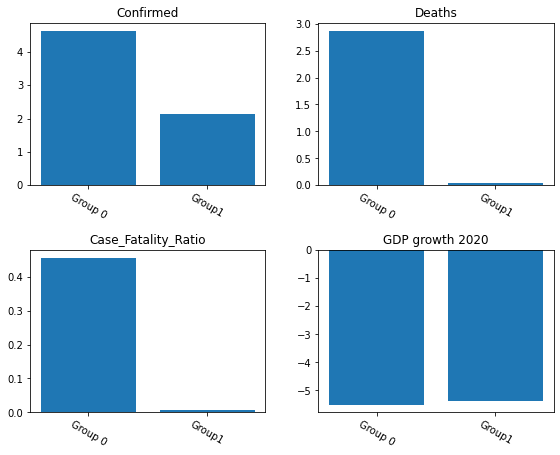

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (8, 6))
ax = ax.flatten()
fig.tight_layout()
fig.subplots_adjust(wspace=0.225, hspace=0.4)

for i in range(4) :
    k= df_summary.index[i]
    ax[i].bar(df_summary.columns, df_summary.loc[k])
    ax[i].set_title(k)
    plt.setp(ax[i].get_xticklabels(), Rotation=-30)
plt.show()

# Discretizing

In [ ]:
y_discretize = np.full(len(df), np.nan)
for i, x in zip(range(len(df)), df['GDP growth 2020']) :
  if x > 20 :
    y_discretize[i] = 5
  elif x >= 10 :
    y_discretize[i] = 4
  elif x >= 0 :
    y_discretize[i] = 3
  elif x >= -10 :
    y_discretize[i] = 2
  elif x >= -20 :
    y_discretize[i] = 1
  else :
    y_discretize[i] = 0

# No members in group 4, so change 5 -> 4
y_discretize[y_discretize==5] = 4

y_discretize = y_discretize.astype(np.int)

In [ ]:
df.loc[y_discretize == 1]

,Confirmed,Deaths,Case_Fatality_Ratio,GDP growth 2020
Country,,,,
Antigua and Barbuda,2.146128,0.698970,0.588574,-17.3
Argentina,6.135509,4.567062,0.568331,-11.8
Bahamas,3.868997,2.214844,0.505719,-14.8
Barbados,2.408240,0.903090,0.573463,-11.6
Belize,3.708506,2.053078,0.504033,-16.0
Ecuador,5.266883,4.118595,0.908856,-11.0
Grenada,1.623249,0.000000,0.000000,-11.8
India,6.959041,5.123855,0.391765,-10.3
Iraq,5.727542,4.076495,0.509875,-12.1


In [ ]:
def print_country(df, x, g) :
  j = 0
  for i in df.loc[x==g].index :
    print(i, end=', ')
    j += 1
    if j%10==0 :
      print()
      j = 0
  print()

for i in range(5) :
  if i != -1 :
    print('Group ' + str(i) + ' ' + '-'*100)
  print_country(df, y_discretize, i)
  print()

Group 0 ----------------------------------------------------------------------------------------------------
Fiji, Lebanon, Venezuela, 

Group 1 ----------------------------------------------------------------------------------------------------
Antigua and Barbuda, Argentina, Bahamas, Barbados, Belize, Ecuador, Grenada, India, Iraq, Italy, 
Kyrgyzstan, Maldives, Mauritius, Montenegro, Peru, Seychelles, Spain, Suriname, Zimbabwe, 

Group 2 ----------------------------------------------------------------------------------------------------
Afghanistan, Albania, Algeria, Angola, Armenia, Australia, Austria, Azerbaijan, Bahrain, Belarus, 
Belgium, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Burkina Faso, Burundi, Cabo Verde, Cambodia, Cameroon, 
Canada, Central African, Chad, Chile, Colombia, Congo (Brazzaville), Congo (Kinshasa), Costa Rica, Croatia, Cyprus, 
Czech, Denmark, Djibouti, Dominica, Dominican Republic, El Salvador, Equatorial Guinea, Estonia, Eswatini, Finland, 
France

In [ ]:
df_mean = pd.DataFrame(df_untransformed.loc[y_discretize==0].mean(), columns=['Group 0'])
for i in range(1, 5) :
  df_mean = df_mean.join(pd.DataFrame(df_untransformed.loc[y_discretize==i].mean(), columns=['Group' + str(i)]))

display(df_mean)

,Group 0,Group1,Group2,Group3,Group4
Confirmed,3.871516,4.325042,4.645599,3.915475,3.707059
Deaths,2.122821,2.660729,2.842338,2.110865,2.158362
Case_Fatality_Ratio,0.449651,0.473324,0.428153,0.397435,0.580671
GDP growth 2020,-23.666667,-13.057895,-5.231356,1.245000,26.200000


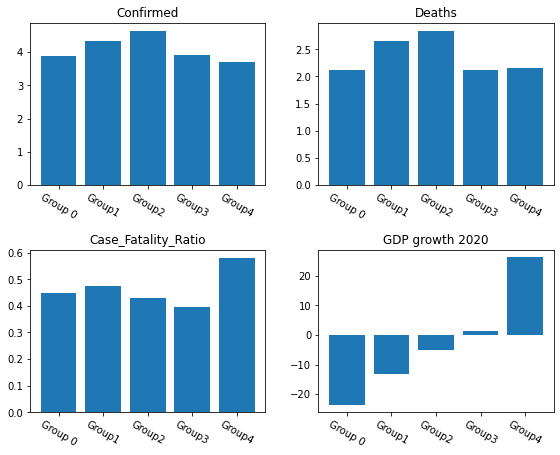

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (8, 6))
ax = ax.flatten()
fig.tight_layout()
fig.subplots_adjust(wspace=0.225, hspace=0.4)

for i in range(4) :
    k= df_mean.index[i]
    ax[i].bar(df_mean.columns, df_mean.loc[k])
    ax[i].set_title(k)
    plt.setp(ax[i].get_xticklabels(), Rotation=-30)
plt.show()

## <b> 2. What is economic structure of the country?</b>


เนื่องจากการแพร่ระบาดของ Covid-19 เกิดจากการสัมผัส หรือ ติดต่อกันผ่านทางระบบทางเดินหายใจ เราจึงตั้งข้อสังเกตุขึ้นมาเพื่อศึกษาพฤติกรรมโครงสร้างทางเศรษฐกิจของแต่ละประเทศ เพื่อศึกษาว่าประเทศนั้นๆมีโอกาสเพิ่มอัตราการแพร่ระบาดอย่างไร จากโครงสร้างของธุรกิจผ่านในประเทศ

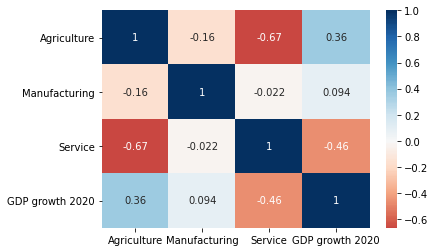

In [ ]:
features = ['Agriculture', 
          'Manufacturing',
          'Service',
          'GDP growth 2020']

df = dat_used[features]
df_untransformed = dat_untransformed[features]

for x in features :
  df[x] = pd.to_numeric(df[x], errors='coerce')

df.dropna(how='any', axis=0, inplace=True)

sns.heatmap(df.corr(), cmap='RdBu', annot=True, center=0)
plt.show()

Regular axes ----------------------------------------------------------------------------------------------------


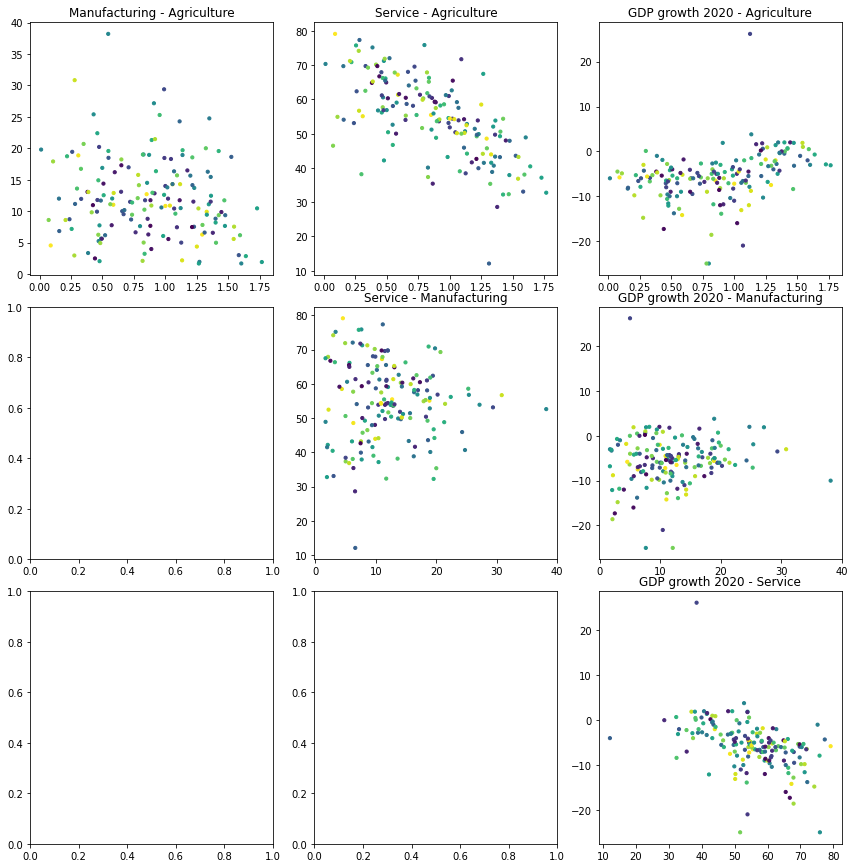

Projection to PCA axes ----------------------------------------------------------------------------------------------------


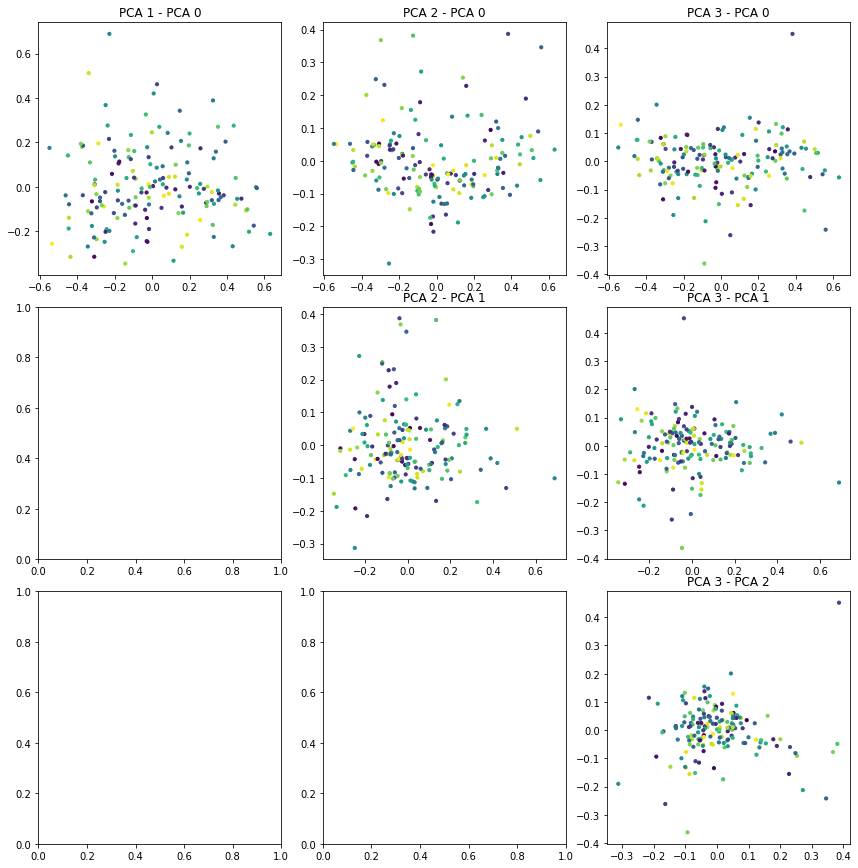

In [ ]:
X = df.values
X_scaled = MinMaxScaler().fit_transform(X)
X_pca    = PCA().fit_transform(X_scaled)
y        = df.values[:, -1]

print('Regular axes ' + '-'*100)
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
fig.tight_layout()

for i in range(4) :
    for j in range(i+1, 4) :
        sc = ax[i][j-1].scatter(X[:, i], X[:, j], s=10, c=np.argsort(y))
        ax[i][j-1].set_title(df.columns[j] + " - " + df.columns[i])
plt.show()

print('Projection to PCA axes ' + '-'*100)

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
fig.tight_layout()

for i in range(4) :
    for j in range(i+1, 4) :
        sc = ax[i][j-1].scatter(X_pca[:, i], X_pca[:, j], s=10, c=np.argsort(y))
        ax[i][j-1].set_title('PCA '+str(j)+" - "+'PCA '+str(i))
plt.show()

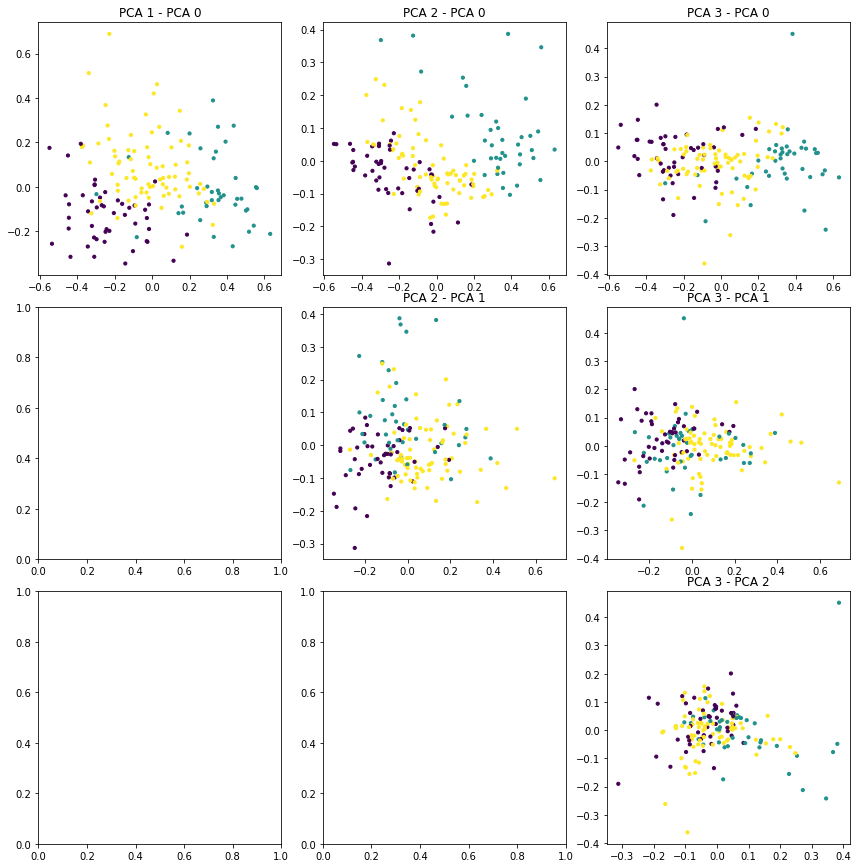

In [ ]:
#y_DBscan = DBSCAN(eps=0.09).fit_predict(X_scaled[:, :-1])
y_kmean  = KMeans(n_clusters=3).fit_predict(X[:, :-1])

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
fig.tight_layout()

for i in range(4) :
    for j in range(i+1, 4) :
        sc = ax[i][j-1].scatter(X_pca[:,i], X_pca[:,j], s=10, c=y_kmean)
        #sc = ax[i][j-1].scatter(X_pca[:,i], X_pca[:,j], s=10, c=y_DBscan)
        ax[i][j-1].set_title('PCA '+str(j)+" - "+'PCA '+str(i))
        
plt.show()

Mean Square Error
0.0


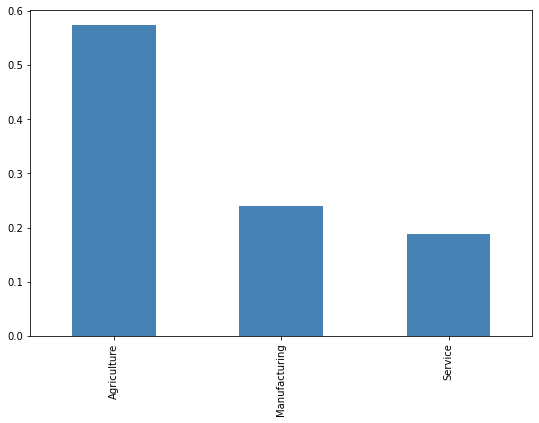

Ranking of feature importance ---------------------------------
1 Agriculture
2 Manufacturing
3 Service


In [ ]:
rgs = DecisionTreeRegressor().fit(X_scaled[:,:-1], y)
#for i, j in zip(y, rgs.predict(X_scaled)) :
#  print(i, j)

print('Mean Square Error')
print(np.sum((df.values[:, -1] - rgs.predict(X_scaled[:, :-1] ))**2)/len(df.index))

plt.figure()
pd.Series(rgs.feature_importances_, index=df.columns[:-1]).plot.bar(color='steelblue', figsize=(9, 6))
plt.show()

print('Ranking of feature importance ---------------------------------')
j = 1
for i in df.columns[np.argsort(rgs.feature_importances_)[::-1]] :
  print(j, i)
  j+=1

ซึ่งเราได้ผลสรุปในช่วงโควิดนั้น โครงสร้างอุตสาหกรรมเป็นหนึ่งในปัจจัยที่ส่งผลกระทบทางตรงและทางอ้อมต่อการเจริญเติบโตทางเศรษฐกิจของประเทศ
โดย เราจะเห็นได้ว่า ความสัมพันธ์ระหว่างอุตสาหกรรมการบริการนั้น มีความสัมพันธ์แบบผกพันกับการเจริญเติบโตทางเศรษฐกิจของประเทศ
เนื่องจากประเทศที่พึงพิงอุตสาหกรรมด้านการบริการ ส่วนใหญ่แล้วจะมีรายได้หลักมาจาก การท่องเที่ยว ซึ่งในช่วงแรกของการที่ยังพึ่งพิงแหล่งรายได้ดังกล่าว ทำให้โอกาสที่เชื้อ Covid-19 จะแพร่ระบาดจากคนสู่คน ผ่านความใกล้ชิดจากการได้รับบริการ

# Discretizing

In [ ]:
y_discretize = np.full(len(df), np.nan)
for i, x in zip(range(len(df)), df['GDP growth 2020']) :
  if x > 20 :
    y_discretize[i] = 5
  elif x >= 10 :
    y_discretize[i] = 4
  elif x >= 0 :
    y_discretize[i] = 3
  elif x >= -10 :
    y_discretize[i] = 2
  elif x >= -20 :
    y_discretize[i] = 1
  else :
    y_discretize[i] = 0

# No members in group 4, so change 5 -> 4
y_discretize[y_discretize==5] = 4

y_discretize = y_discretize.astype(np.int)

In [ ]:
def print_country(df, x, g) :
  j = 0
  for i in df.loc[x==g].index :
    print(i, end=', ')
    j += 1
    if j%10==0 :
      print()
      j = 0
  print()

for i in range(5) :
  if i != -1 :
    print('Group ' + str(i) + ' ' + '-'*100)
  print_country(df, y_discretize, i)
  print()

Group 0 ----------------------------------------------------------------------------------------------------
Fiji, Lebanon, Venezuela, 

Group 1 ----------------------------------------------------------------------------------------------------
Antigua and Barbuda, Argentina, Bahamas, Barbados, Belize, Ecuador, Grenada, India, Iraq, Italy, 
Kyrgyzstan, Maldives, Mauritius, Montenegro, Peru, Seychelles, Spain, Suriname, Zimbabwe, 

Group 2 ----------------------------------------------------------------------------------------------------
Afghanistan, Albania, Algeria, Angola, Armenia, Australia, Austria, Azerbaijan, Bahrain, Belarus, 
Belgium, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Burkina Faso, Burundi, Cabo Verde, Cambodia, Cameroon, 
Canada, Central African, Chad, Chile, Colombia, Congo (Brazzaville), Congo (Kinshasa), Costa Rica, Croatia, Cyprus, 
Czech, Denmark, Djibouti, Dominica, Dominican Republic, El Salvador, Equatorial Guinea, Estonia, Eswatini, Finland, 
France

In [ ]:
print('group 0')
display(df_untransformed.loc[y_discretize==0])

print('group 1')
display(df_untransformed.loc[y_discretize==1])

print('group 2')
display(df_untransformed.loc[y_discretize==2])

print('group 3')
display(df_untransformed.loc[y_discretize==3])

print('group 4')
display(df_untransformed.loc[y_discretize==4])

group 0


,Agriculture,Manufacturing,Service,GDP growth 2020
Country,,,,
Fiji,10.745250,10.42302,53.90812,-21.0
Lebanon,5.290000,7.62000,75.90000,-25.0
Venezuela,5.026754,12.07336,51.66748,-25.0


group 1


,Agriculture,Manufacturing,Service,GDP growth 2020
Country,,,,
Antigua and Barbuda,1.757789,2.486629,66.75313,-17.3
Argentina,7.200783,12.837760,53.62626,-11.8
Bahamas,0.890982,2.954646,74.20178,-14.8
Barbados,1.995424,7.743095,71.26328,-11.6
Belize,9.563394,5.571690,65.50795,-16.0
Ecuador,8.996839,14.008320,51.85350,-11.0
Grenada,5.835540,3.227927,66.33203,-11.8
India,15.964600,13.700000,49.90000,-10.3
Iraq,2.000000,2.050000,42.20000,-12.1


group 2


,Agriculture,Manufacturing,Service,GDP growth 2020
Country,,,,
Afghanistan,21.134390,11.102530,52.08388,-5.0
Albania,18.627490,6.282522,48.58177,-7.5
Algeria,11.974390,24.282960,45.93583,-5.5
Angola,8.607742,6.059469,43.20691,-4.0
Armenia,11.988360,11.739390,54.23384,-4.5
Australia,2.085253,5.647925,66.14989,-4.2
Austria,1.134728,16.739510,62.54563,-6.7
Azerbaijan,5.716874,5.012549,37.36046,-4.0
Bahrain,0.281718,17.912620,54.93431,-4.9


group 3


,Agriculture,Manufacturing,Service,GDP growth 2020
Country,,,,
Bangladesh,12.680270,18.932630,52.84933,3.8
Benin,26.875800,9.865728,48.02682,2.0
Bhutan,15.888550,7.528183,39.92838,0.6
Brunei,0.986055,13.602220,38.17760,0.1
China,7.111634,27.165670,53.91583,1.9
Cote d'Ivoire,15.694820,11.523640,53.87854,1.8
Ethiopia,33.884800,5.583015,36.86600,1.9
Ghana,17.306350,10.436740,44.14261,0.9
Guinea,20.343370,9.444597,41.53664,1.4


group 4


,Agriculture,Manufacturing,Service,GDP growth 2020
Country,,,,
Guyana,12.37024,5.004538,38.4335,26.2


In [ ]:
df_mean = pd.DataFrame(df_untransformed.loc[y_discretize==0].mean(), columns=['Group 0'])
for i in range(1, 5) :
  df_mean = df_mean.join(pd.DataFrame(df_untransformed.loc[y_discretize==i].mean(), columns=['Group' + str(i)]))
display(df_mean)

,Group 0,Group1,Group2,Group3,Group4
Agriculture,7.020668,5.998455,9.132189,21.232237,12.370240
Manufacturing,10.038793,8.736870,12.806990,11.643024,5.004538
Service,60.491867,60.921184,55.727752,43.432302,38.433500
GDP growth 2020,-23.666667,-13.057895,-5.231356,1.245000,26.200000


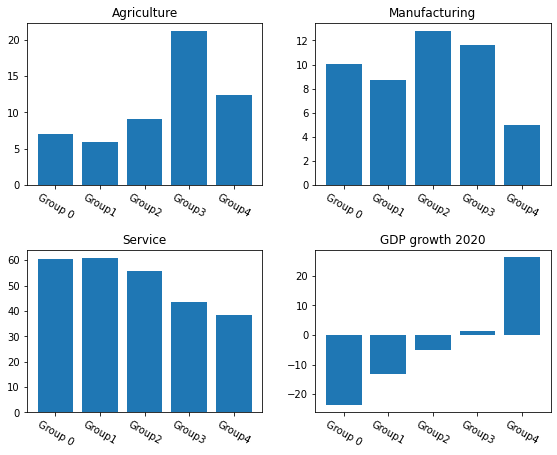

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (8, 6))
ax = ax.flatten()
fig.tight_layout()
fig.subplots_adjust(wspace=0.225, hspace=0.4)

for i in range(4) :
    k= df_mean.index[i]
    ax[i].bar(df_mean.columns, df_mean.loc[k])
    ax[i].set_title(k)
    plt.setp(ax[i].get_xticklabels(), Rotation=-30)
plt.show()

## <b> 3. Does country have readiness to handle pandemics? </b>


ในแต่ละประเทศมีการเตรียมพร้อมและมาตราการรับมือกับการแพร่ระบาดของ Covid-19 ในช่วงแรก เราได้นำข้อมูลมาศึกษาเพิ่มเพื่อดูศักยภาพของแต่ละประเทศว่า ได้รับมือและความพร้อมที่จะบรรเทาความอัตราการเสียชีวิตจากการแพร่ระบาดในครั้งนี้ได้หรือไม่

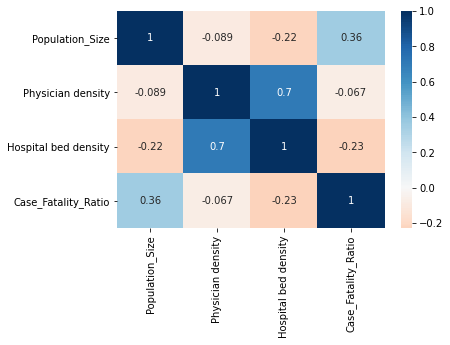

In [ ]:
features = ['Population_Size', 
          'Physician density',
          'Hospital bed density',
          'Case_Fatality_Ratio']

df = dat_used[features]
df_untransformed = dat_untransformed[features]

for x in features :
  df[x] = pd.to_numeric(df[x], errors='coerce')

df.dropna(how='any', axis=0, inplace=True)

sns.heatmap(df.corr(), cmap='RdBu', annot=True, center=0)
plt.show()

Regular axes ----------------------------------------------------------------------------------------------------


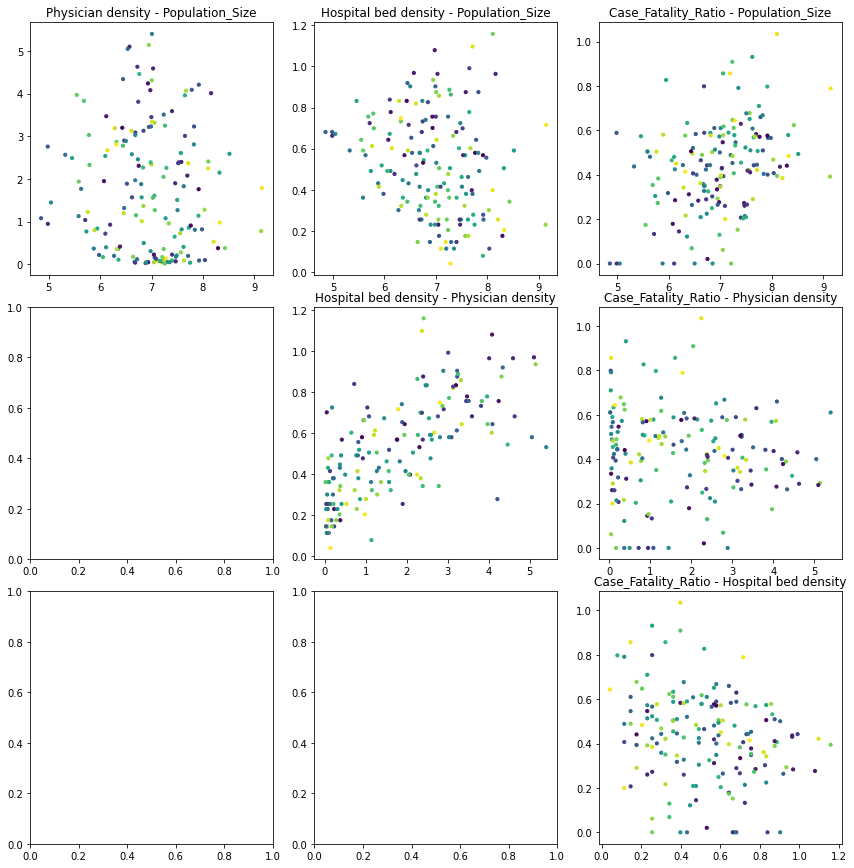

Projection to PCA axes ----------------------------------------------------------------------------------------------------


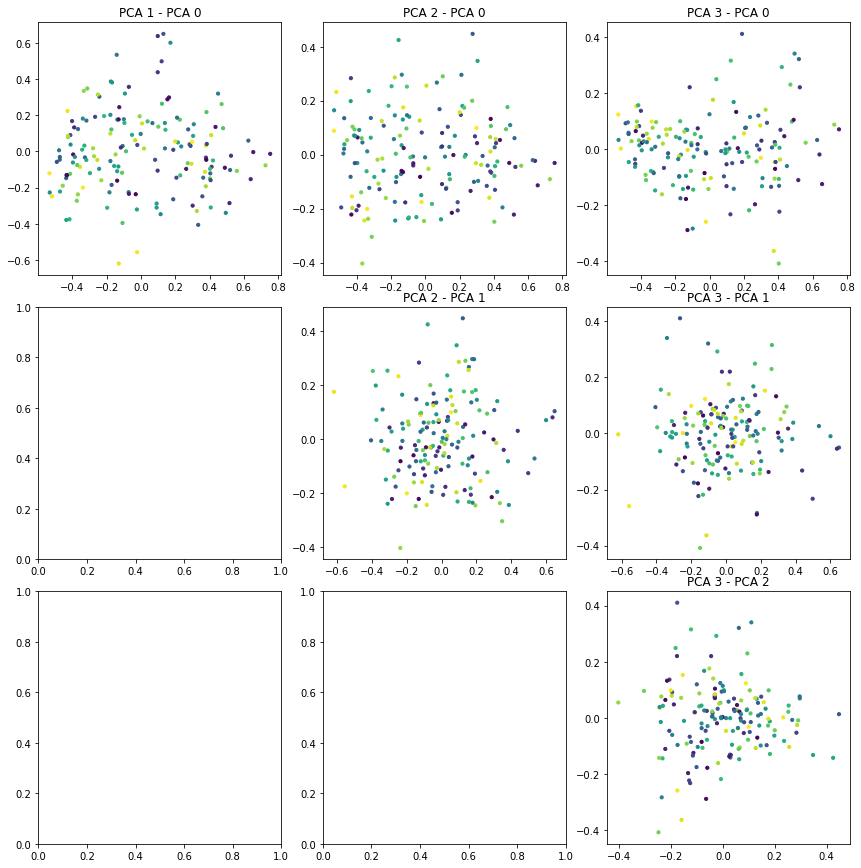

In [ ]:
X = df.values
X_scaled = MinMaxScaler().fit_transform(X)
X_pca    = PCA().fit_transform(X_scaled)
y        = df.values[:, -1]

print('Regular axes ' + '-'*100)
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
fig.tight_layout()

for i in range(4) :
    for j in range(i+1, 4) :
        sc = ax[i][j-1].scatter(X[:, i], X[:, j], s=10, c=np.argsort(y))
        ax[i][j-1].set_title(df.columns[j] + " - " + df.columns[i])
plt.show()

print('Projection to PCA axes ' + '-'*100)

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
fig.tight_layout()

for i in range(4) :
    for j in range(i+1, 4) :
        sc = ax[i][j-1].scatter(X_pca[:, i], X_pca[:, j], s=10, c=np.argsort(y))
        ax[i][j-1].set_title('PCA '+str(j)+" - "+'PCA '+str(i))
plt.show()

Mean Square Error
0.0


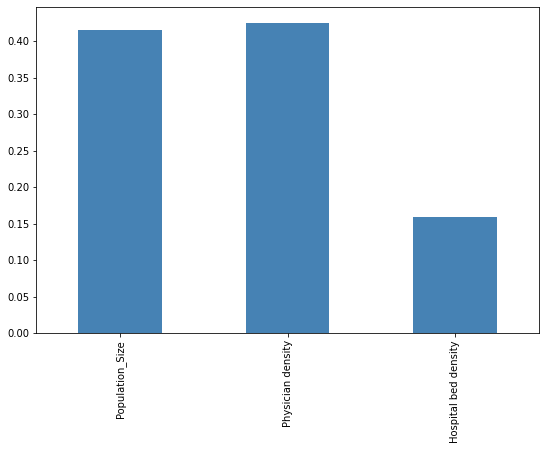

Ranking of feature importance ---------------------------------
1 Physician density
2 Population_Size
3 Hospital bed density


In [ ]:
rgs = DecisionTreeRegressor().fit(X_scaled[:,:-1], y)
#for i, j in zip(y, rgs.predict(X_scaled)) :
#  print(i, j)

print('Mean Square Error')
print(np.sum((df.values[:, -1] - rgs.predict( X_scaled[:, :-1] ))**2)/len(df.index))

plt.figure()
pd.Series(rgs.feature_importances_, index=df.columns[:-1]).plot.bar(color='steelblue', figsize=(9, 6))
plt.show()

print('Ranking of feature importance ---------------------------------')
j = 1
for i in df.columns[np.argsort(rgs.feature_importances_)[::-1]] :
  print(j, i)
  j+=1

เราจะเห็นได้ชัดว่าในแต่ละประเทศมีจำนวนประชาชนแตกต่างกัน ซึ่งอาจจะเป็นปัจจัยสำคัญอย่างนึงที่ทำให้ประเทศนั้นๆมีประชาชนติดเชื้อ Covid-19 เพิ่มขึ้นอย่างต่อเนื่อง แต่สิ่งสำคัญที่ทำให้อัตราการเสียชีวิตของผู้คนในประเทศนั้นๆ อาจจะมีที่มาจากบุคคลากรทางการแพทย์ หรือ เครื่องมือทางการแพทย์ที่จะทำให้ประเทศนั้นๆรักษาผู้ป่วยและลดทอนอัตราการเสียชีวิตได้อย่างมาก

# Discretizing

In [ ]:
y_discretize = np.full(len(df), np.nan)
for i, x in zip(range(len(df)), dat_untransformed['Case_Fatality_Ratio']) :
  if x >= 5 :
    y_discretize[i] = 3
  elif x >= 3 :
    y_discretize[i] = 2
  elif x >= 1 :
    y_discretize[i] = 1
  else :
    y_discretize[i] = 0

y_discretize = y_discretize.astype(np.int)

In [ ]:
def print_country(df, x, g) :
  j = 0
  for i in df.loc[x==g].index :
    print(i, end=', ')
    j += 1
    if j%10==0 :
      print()
      j = 0
  print()

for i in range(4) :
  if i != -1 :
    print('Group ' + str(i) + ' ' + '-'*100)
  print_country(df, y_discretize, i)
  print()

Group 0 ----------------------------------------------------------------------------------------------------
Austria, Bahrain, Belarus, Bhutan, Botswana, Burundi, Cambodia, Cyprus, Cote d'Ivoire, Dominica, 
Estonia, Gabon, Georgia, Ghana, Grenada, Guinea, Iceland, Israel, Kuwait, Laos, 
Lebanon, Lithuania, Luxembourg, Malaysia, Maldives, Mongolia, Mozambique, Nepal, Norway, Qatar, 
Rwanda, Seychelles, Singapore, Slovakia, Sri Lanka, Timor-Leste, Uganda, United Arab Emirates, Uzbekistan, Venezuela, 


Group 1 ----------------------------------------------------------------------------------------------------
Albania, Angola, Antigua and Barbuda, Argentina, Armenia, Azerbaijan, Bahamas, Bangladesh, Barbados, Belgium, 
Belize, Benin, Bosnia and Herzegovina, Brazil, Brunei, Burkina Faso, Cabo Verde, Cameroon, Central African, Chile, 
Colombia, Congo (Brazzaville), Congo (Kinshasa), Costa Rica, Croatia, Czech, Denmark, Djibouti, Dominican Republic, El Salvador, 
Equatorial Guinea, Eswatini,

In [ ]:
df_mean = pd.DataFrame(df_untransformed.loc[y_discretize==0].mean(), columns=['Group 0'])
for i in range(1, 4) :
  df_mean = df_mean.join(pd.DataFrame(df_untransformed.loc[y_discretize==i].mean(), columns=['Group' + str(i)]))

display(df_mean)

,Group 0,Group1,Group2,Group3
Population_Size,1.045778e+07,4.665231e+07,4.442454e+07,1.711662e+08
Physician density,1.819250e+00,1.852695e+00,1.514375e+00,1.023000e+00
Hospital bed density,3.310000e+00,3.106526e+00,1.681250e+00,1.310000e+00
Case_Fatality_Ratio,5.121394e-01,1.945780e+00,3.398869e+00,6.344541e+00


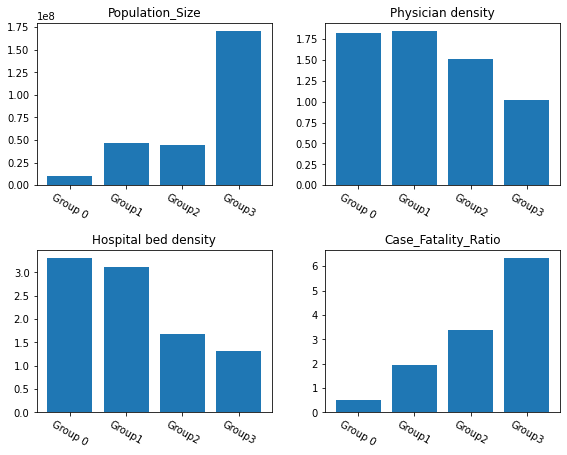

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (8, 6))
ax = ax.flatten()
fig.tight_layout()
fig.subplots_adjust(wspace=0.225, hspace=0.4)

for i in range(4) :
    k= df_mean.index[i]
    ax[i].bar(df_mean.columns, df_mean.loc[k])
    ax[i].set_title(k)
    plt.setp(ax[i].get_xticklabels(), Rotation=-30)
plt.show()

# <b> 4 Summary  </b>

เราปฏิเสธไม่ได้เลยว่าการแพร่ระบาดของเชื้อ Covid-19 ในรอบนี้ ส่งผลกระทบต่อชีวิตของผู้คน และต่อเศรษฐกิจในแต่ละประเทศอย่างมาก เพราะเนื่องจากจะมีการปิดประเทศ ปิดระบบขนส่งต่างๆ ทำให้การติดต่อค้าขายนั้นเป็นเรื่องยากลำบากเพื่อเข้าควบคุมสถานการณ์การระบาด


In [ ]:
summary = dat_used

# **Comparison**

การเปรียบเทียบและกรณีศึกษาจากของเรื่อง อัตราการเจริญเติบโตทางเศรษฐกิจ , โครงสร้างของประเทศ , และ ความรุนแรงและอัตราการเสียชีวิตของประเทศนั้นๆ

In [ ]:
summary.loc['Thailand']

Confirmed                3.592621
Deaths                   1.785330
Incident_Rate            5.606019
Case_Fatality_Ratio      0.403695
latest GDP               7.227267
latest GDP capita        3.892606
Agriculture              0.954448
Industry                33.402620
Manufacturing           25.300120
Service                 58.593110
Population_Size          7.841538
Hospital bed density     0.491362
Physician density        0.810000
GDP growth 2020         -7.100000
Name: Thailand, dtype: float64

ประเทศไทยอยู่ในกลุ่มที่ 1
ถึงแม้ประเทศไทยจะมีโครงสร้างทางเศรษฐกิจที่เป็นภาคบริการเยอะ ทำให้เศรษฐกิจของประเทศได้รับผลจากการแพร่ระบาดอย่างหนัก ทว่าประเทศไทยนั้นเป็นประเทศที่มีบุคคลากรและอุปกรณ์ทางการแพทย์มารองรับทำให้อัตราการเสียชีวิตนั้นอยู่ในเกณฑ์ที่สามารถควบคุมได้ดี
แต่ทว่าเพียงตัวเลขเท่านี้ยังไม่ได้รวมถึงมาตราการของทางภาครัฐ ซึ่งจะทำให้เราเข้าใจสภาพและความเข้มข้นของการรับมือในประเทศไทยมีประสิทธิภาพมากน้อยกว่าประเทศอื่นอย่างไร

In [ ]:
summary.loc['Indonesia']

Confirmed                 5.692848
Deaths                    4.198685
Incident_Rate           180.000000
Case_Fatality_Ratio       0.623249
latest GDP               10.198657
latest GDP capita         3.617105
Agriculture               1.136721
Industry                 38.900000
Manufacturing            19.700000
Service                  44.200000
Population_Size           8.428135
Hospital bed density      0.342423
Physician density         0.380000
GDP growth 2020          -1.500000
Name: Indonesia, dtype: float64

ประเทศอินโดเนเซียก็เป็นอีกประเทศนึงที่ Machine ได้จัดให้อยู่ในกลุ่มที่ 1

เมื่อนำข้อมูลมาเปรียบเทียบกับประเทศไทย ถึงแม้โครงสร้างอุตสาหกรรมจะค่อนข้างใกล้กับของประเทศไทย ซึ่งมีรายได้จากอุตสาหกรรมบริการเป็นหลัก แต่เราจะเห็นได้ชัดว่า ประเทศอินโดเนเซียมีจำนวนผู้ติดเชื้อมากกว่าไทยเป็นอย่างมาก ซึ่งส่วนนึงมาจากประชากรของประเทศอินโดเนเซียนั้นมีมากกว่าประเทศไทย อยู่ถึง เกือบ 4 เท่า จึงไม่น่าแปลกใจที่ตัวเลขของผู้ติดเชื้อจะมากกว่าประเทศไทยได้อย่างชัดเจน

แต่ทว่าพอมีศึกษาเรื่องอัตราการเสียชิวิตของผู้ติดเชื้อในประเทศอินโดเนเซีย เป็นที่ไม่น่าแปลกใจเลยที่ทำไมตัวเลขผู้เสียชีวิตจึงมากกว่าประเทศไทย เพราะประเทศอินโดเนเซียขาดแคลนบุคคลากรทางการแพทย์ และเครื่องมือทางการแพทย์น้อยกว่าประเทศไทยเป็นอย่างมาก นี่อาจจะทำให้การรับมือหรือความพร้อมทางการแพทย์ของประเทศอินโดเนเซียเป็นเรื่องท้าทายในอนาคต ซึ่งถ้าหากมีการแพร่ระบาดเชื้อที่ร้ายแรงกว่านี้ หากอินโดเนเซียไม่เพิ่มศักยภาพทางการแพทย์ในประเทศ ก็คงเป็นเรื่องยากที่จะเผชิญกับโรคที่อาจจะมีความรุนแรงกว่านี้ในอนาคต